In [1]:
# Arabic Corpus 
!gdown 1eAxFn4bg8nHETERVE7WBr2EfNPHNGpsY

# Arabic Stopwords 
!gdown 1RkGIla7KRXEkg0PudnOMDSAFJTDuoOwy

Downloading...
From: https://drive.google.com/uc?id=1eAxFn4bg8nHETERVE7WBr2EfNPHNGpsY
To: /content/arabiccorpus.docx
100% 2.17M/2.17M [00:00<00:00, 136MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RkGIla7KRXEkg0PudnOMDSAFJTDuoOwy
To: /content/list.txt
100% 6.48k/6.48k [00:00<00:00, 7.35MB/s]


In [2]:
pip install python-docx PyArabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 30.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 KB 8.3 MB/s eta 0:00:00
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184505 sha256=597898c6e7673e3b8fb8aab6a863a8a792e07423d5cb209f028b7eb2adda605a
  Stored in directory: /root/.cache/pip/wheels/32/b8/b2/c4c2b95765e615fe139b0b17b5ea7c0e1b6519b0a9ec8fb34d
Successfully built python-docx


In [3]:
# Important Variables 

window_size = 2
embed_size = 100
WordCount = 20000

In [4]:
# Libraries Needed 

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from docx import Document
import re
import pyarabic.araby as araby
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, Dense
from tensorflow.keras.utils import to_categorical
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# Prepare Stopwords
txt_file = open("list.txt", "r", encoding="utf8")
file_content = txt_file.read()
stopwords = file_content.split("\n")
txt_file.close()

## Functions 

In [6]:
def getCorpus():
    document = Document("./arabiccorpus.docx")
    text = ""
    for paragraph in document.paragraphs:
        text += paragraph.text
    return text

In [7]:
def normalizeArabic(text):
    search = ["أ", "إ", "آ", "ة", "_", "-", "/", ".", "،", " و ", " يا ", '"', "ـ",
              "'", "ى", "\\", '\n', '\t', '&quot;', '?', '؟', '!', '(', ')', '\n', '=',':','×','؛',
              '💔','😔','😩','😐','😭','😢','😞',
              '💙','😂','💕','🌸','😍','❤','💖',
              ]
    replace = ["ا", "ا", "ا", "ه", " ", " ", "", " ", " ", " و", " يا", " ", " ",
               " ", "ي", " ", ' ', ' ', ' ', ' ? ', ' ؟ ', ' ! ', ' ', ' ', ' ', ' ',' ',' ',' ',
               " محزن "," محزن "," محزن "," محزن "," محزن "," محزن "," محزن ",
               'مسعد','مسعد','مسعد','مسعد','مسعد','مسعد','مسعد',
               ]
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = remove_emoji(text)
    text = re.sub(r'\s*[A-Za-z]+\b', ' ' , text)
    text = re.sub('[a-zA-Z0-9_]|#|http\S+', '', text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text)  # Remove longation
    return araby.strip_tashkeel(text)

In [8]:
def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [9]:
def filterSentence(text):
    filtered_sentence = []
    for w in text:
        if w not in stopwords:
            filtered_sentence.append(w)
    return filtered_sentence

In [10]:
def getWindows(Words, C):
    i = C
    label = []
    Context = []
    while i < len(Words) - C:
        center_word = Words[i]
        context_words = Words[(i - C):i] + Words[(i+1):(i+C+1)]
        Context.append(context_words)
        label.append(center_word)
        i += 1
    Context = np.array(Context)
    label = np.array(label)
    return Context,label

In [11]:
def getVocab(text):
    token_index = {}
    token_index.update({'UNK': 0})
    counter = 0
    for considered_word in text:
        if considered_word not in token_index:
            token_index.update({considered_word: counter + 1})
            counter = counter + 1
    return token_index

In [12]:
def numericalValues(context, labels, token_index):
    for i in range(len(labels)):
        labels[i] = token_index[labels[i]]

    for row in range(len(context)):
        for j in range(len(context[row])):
            context[row][j] = token_index[context[row][j]]

    return context,labels

In [13]:
def oneHotVectorLabels(labels):
    labelsVec = np.empty((len(labels),len(vocab)))
    for i in range(len(labels)):
      labelsVec[i]= to_categorical(getInt(labels[i]),num_classes=len(vocab))
    
    return labelsVec

In [14]:
def oneHotVectorLabelsYield(labels):
    for i in range(len(labels)):
      yield to_categorical(getInt(labels[i]),num_classes=len(vocab))

In [23]:
def oneHotVectorContext(context):
    inputData = np.empty((len(context),len(vocab)))
    counter=0
    for seq in context:
        emptyvector = np.zeros(len(vocab))
        for word in seq:
            emptyvector+= to_categorical(getInt(word),num_classes=len(vocab))
        emptyvector = emptyvector/4
        inputData[counter]= emptyvector
        counter+=1

    return inputData


In [25]:
def oneHotVectorContextYield(context):
    for seq in context:
        emptyvector = np.empty(len(vocab))
        for word in seq:
            emptyvector += to_categorical(getInt(word),num_classes=len(vocab))
        emptyvector /= 4

        yield  emptyvector


In [17]:
def getInt(word):
  if word in vocab:
    return vocab[word]
  else:
    return 0

In [18]:
# Prepare Corpus 
corpus = getCorpus()
corpus = normalizeArabic(corpus)
corpus = word_tokenize(corpus)
corpus = filterSentence(corpus)


In [19]:
# Get A vocab list 
vocab = getVocab(corpus)

In [20]:
print("Number of Unique Words is:",len(vocab),"Word")

Number of Unique Words is: 14041 Word


In [21]:
# Get Context Words and Target  
context, labels = getWindows(corpus, 2)

In [24]:
context2 = oneHotVectorContext(context)

In [26]:
label2 = oneHotVectorLabels(labels)

In [27]:
len(vocab)

14041

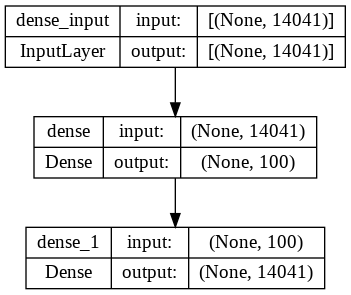

In [28]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.utils import plot_model

CBOW = Sequential([
    Dense(units=100, input_shape=(len(vocab),)),
    Dense(units=len(vocab),activation="softmax")
])

# Plot model graph
plot_model(CBOW, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [29]:
CBOW.compile(loss='categorical_crossentropy', optimizer='adam')

In [30]:
history = CBOW.fit(context2, label2, epochs=10) #, batch_size=32

Epoch 1/10
915/915 [==============================] - 30s 32ms/step - loss: 9.3220
Epoch 2/10
915/915 [==============================] - 29s 32ms/step - loss: 8.7876
Epoch 3/10
915/915 [==============================] - 29s 31ms/step - loss: 8.5259
Epoch 4/10
915/915 [==============================] - 32s 35ms/step - loss: 8.2311
Epoch 5/10
915/915 [==============================] - 29s 32ms/step - loss: 7.8435
Epoch 6/10
915/915 [==============================] - 29s 32ms/step - loss: 7.3818
Epoch 7/10
915/915 [==============================] - 29s 32ms/step - loss: 6.8576
Epoch 8/10
915/915 [==============================] - 29s 32ms/step - loss: 6.2752
Epoch 9/10
915/915 [==============================] - 29s 32ms/step - loss: 5.6527
Epoch 10/10
915/915 [==============================] - 29s 32ms/step - loss: 5.0112


In [31]:
weights = CBOW.get_weights()[0]
print(len(weights))

14041


In [32]:
counter=0
counter

0

In [33]:
w2v_my = {}
counter =0
for word in vocab:
    w2v_my[word] = weights[counter]
    counter+=1
print(len(weights))

14041


In [34]:
np.savez('embeddings.npz', **w2v_my)
embeddings = np.load('embeddings.npz')

# check existing words (keys)
print(embeddings.files)

# get embeddings for some specific word
print(embeddings['بسم'])

['UNK', 'بسم', 'الله', 'الرحمن', 'الرحيم', 'الحمد', 'لله', 'والصلاه', 'والسلام', 'رسول', 'وعلي', 'اله', 'وصحبه', 'والاه', 'فهذه', 'المجموعه', 'الاولي', 'مقالات', 'لكبار', 'كتاب', 'العربيه', 'العصر', 'الحديث', 'وقبل', 'الكلام', 'المقالات', 'يحسن', 'المقاله', 'نشاتها', 'ومفهومها', 'وموضوعها', 'وانواعها', 'يدور', 'الفلك', 'فالمقاله', 'المقال', 'باب', 'عظيم', 'ابواب', 'العلم', 'وطريق', 'واسع', 'لنشر', 'الفكر', 'والتاثير', 'الناس', 'ولقد', 'عرفت', 'ظهور', 'المطابع', 'وانتشار', 'الصحافه', 'اواخر', 'القرن', 'الثالث', 'الهجري', 'وذلك', 'انشءت', 'صحيفه', 'الوقاءع', 'المصريه', 'بلغت', 'اوجها', 'منتصف', 'الرابع', 'ازدهرت', 'حركتها', 'البلاد', 'وصارت', 'عماد', 'الكتاب', 'والادباء', 'والقالب', 'يصبون', 'افكارهم', 'وينشرونها', 'وليست', 'غريبه', 'الادب', 'العربي', 'القديم', 'تغيرت', 'صيغها', 'وشروطها', 'فعبدالحميد', 'الكاتب', 'يتكلم', 'الصيد', 'الكتابه', 'يكتب', 'شيءا', 'قريبا', 'والفصول', 'الادبيه', 'انشاها', 'ابن', 'المقفع', 'الصغير', 'والادب', 'الكبير', 'اشبه', 'بالمقالات', 'المطوله', 'وكذلك', 'صن